In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#import random


def random_complex_vector(n=1, max_norm=1, fixed_norm=True):
    """
    Returns a complex vector of dimension n x 1 (defaults to 1 x 1).
    Complex elements have norm ]0,max_norm] uniformly randomly, or norm max_norm if fixed_norm == True
    """
    ret = np.empty(n,dtype=np.complex_)
    for i in range(n):
        if fixed_norm:
            norm = max_norm*(1-random.random()) #to have ]0,max_norm]
        else:
            norm = max_norm
        ang = 2*np.pi*random.random()
        ret[i] = max_norm*np.exp((0+1j)*ang)
    return ret

def random_complex_vector(n=1, distribution='gaussian', param=1/np.sqrt(2)):
    assert distribution in ['gaussian','uniform','fixed_norm'], \
        f"Parameter distribution can not be {distribution}"
    if distribution=='gaussian':
        return np.random.normal(loc=0,scale=param,size=n) + \
            (0+1j)*np.random.normal(loc=0,scale=param,size=n)
    else:
        ret = np.empty(n,dtype=np.complex_)
        for i in range(n):
            if distribution=='fixed_norm':
                norm = param*(1-random.random()) #to have ]0,param]
            elif distribution=='uniform':
                norm = param
            ang = 2*np.pi*random.random()
            ret[i] = norm*np.exp((0+1j)*ang)
    return ret

In [93]:
def random_complex_vector(length=1, distribution='gaussian', param=1/np.sqrt(2)):
    """
    Returns a complex vector of dimension length x 1
    If distribution=='gaussian', complex elements are as x+iy, with x,y ~N(0,param^2), param is std
    If distribution=='uniform', complex elements have norm ]0,param] uniformly randomly, phase ]0,2pi] uniformly randomly
    If distribution=='fixed_norm', complex elements have norm param, phase ]0,2pi] uniformly randomly
    If distribution=='real_gaussian', x ~N(0,param^2), param is std, y=0
    If distribution=='real_uniform', x has norm ]0,param] uniformly randomly, y=0

    Complex standard normal (gaussian) distribution has variance 1/2 over the real and over the imaginary part (total variance 1)
    The real one has 1
    """
    assert distribution in ['gaussian','uniform','fixed_norm','real_gaussian','real_uniform'], \
        f"Parameter distribution can not be {distribution}"

    if distribution=='gaussian':
        return np.random.normal(loc=0,scale=param,size=length) + \
            (0+1j)*np.random.normal(loc=0,scale=param,size=length)
    elif distribution=='fixed_norm':
        return param*np.exp(2*np.pi*(0+1j)*np.random.random(length))
    elif distribution=='uniform':
        return param*(1 - np.random.random(length))*np.exp(2*np.pi*(0+1j)*np.random.random(length)) #to have norm in ]0,param]
    elif distribution=='real_gaussian':
        return param*np.random.normal(loc=0,scale=param,size=length)
    elif distribution=='real_uniform':
        return param*(1 - np.random.random(length))*np.random.choice([-1,1],1)

vec = random_complex_vector(100000,'gaussian',1/np.sqrt(2))
plt.hist2d(np.real(vec),np.imag(vec), [200,200])
plt.show

np.var(random_complex_vector(10000))

In [94]:
def define_w_hat(dim,complex=True):
    """
    Returns a complex vector of dimension d x 1, the "teacher" vector to be found.
    Its components are randomly initialized: its norm is in [0,1[, its phase in [0,2pi[.
    Its complex norm squared is d (which means its numpy.linalg.norm is the root of d)

    If complex=False, returns a real vector of squared norm d
    """
    #assert isinstance(dim,int) and dim > 0, f"Given variable dim should not be {dim}"
    if complex:
        ret = random_complex_vector(dim,'uniform',1)
    else:
        ret = random_complex_vector(dim,'real_uniform',1)
    return np.sqrt(dim)*ret/np.linalg.norm(ret)

d = 102
np.linalg.norm(define_w_hat(d))

In [96]:
def define_X(n,d,law='gaussian',param=1/np.sqrt(2)):
    """
    Returns a matrix of dimension n x d, that is the data.
    If law=='gaussian', its rows are complex standard normally distributed, meaning x+iy with x,y~N(0,1/2)
    If law=='real_gaussian', its rows are standard normally distributed, meaning x+iy with x~N(0,1), y=0
    """
    mat = np.empty((n,d),dtype=np.complex_)
    for i in range(n):
        mat[i] = random_complex_vector(d,law,param)
    return mat

In [5]:
def define_y(X,w_hat):
    """
    Returns an array of dimension n x 1, built from the data X and the teacher vector w_hat
    It keeps only the modulus of every element, that should be in principle in [0,1]
    (but can be bigger if the dimension of w_hat is finite)
    """
    return np.abs(X@w_hat)/np.sqrt(len(w_hat))

$\nu(h,h_0) = \frac{1}{2}(|h|^2-|h_0|^2)^2$
Could very simply be optimized in the code by not taking the norm of $h_0$ which will be a positive real number, $y^i$, anyways. Could also be optimized (like its derivative) with $h\cdot h^*$ rather than np.abs(h)**2

In [6]:
def cost(h,h_0):
    """
    The cost function "mu", comparing |X^i@w| to the value y^i=|X^i@w_hat| it corresponds to, minimized in that value
    USELESS wait this function is useless
    """
    return (np.abs(h)**2-np.abs(h_0)**2)**2/2

We will first implement $\partial_1\nu(h,h_0) = 2(|h|^2-|h_0|^2)\cdot h$ (assumes $\frac{d}{dz} |z|^2 = 2z$)

$\partial_1\nu(h,h_0) = (|h|^2-|h_0|^2)\cdot h^*$ would be the Wirtinger derivative (assumes $\frac{d}{dz} |z|^2 = z^*$)

In [207]:
def cost_der_1(h,h_0):
    """
    The derivative of the cost function "mu" in its first argument, h
    """
    return 2*(np.abs(h)**2-np.abs(h_0)**2)*h

$s^i(t) = \left\{ \begin{array}{ll} 1 \text{ with probability b} \\
0 \text{ with probability 1-b} \end{array} \right.$
$b \in ]0,1]$

In [267]:
def isinbatch(b,n):
    """
    Gives a vector s_new with each element 1 with a probability b, or 0 otherwise.
    Vector of functions s^i(t)
    """
    s_new = np.empty(n)
    for i in range(n):
        s_new[i] = np.random.choice([1,0],p=[b,1-b])
    return s_new

\begin{split}
        & s^i(t=0) = \left\{
        \begin{array}{ll}
            1 \text{ with probability } b \\
            0 \text{ with probability } 1-b
        \end{array}
        \right.
        \\
        & \mathbb{P}\left(s^i(t+\eta) = 1 | s^i(t) = 0\right) = \frac{\eta}{\tau} \\
        & \mathbb{P}\left(s^i(t+\eta) = 0 | s^i(t) = 1\right) = \frac{1 - b}{b \tau}\eta.
    \end{split}

def iterative_isinbatch(b,eta,tau,s_last):
    """
    The function s^i when defined iteratively, takes its precedent state into account.
    Should NOT be called for t=0, this value should be obtained via isinbatch().
    Allows to remove a test for every iteration of this function
    """
    prob_1 = eta/tau*(1-s_last) + (1-(1/b-1)*tau/eta)*s_last
    prob_0 = 1-prob_1
    return np.random.choice([1,0],p=[prob_1,prob_0])


In [9]:
def iterative_isinbatch(b,eta,tau,s_last):
    """
    The vector of functions s^i(t) when defined iteratively, takes its precedent state into account
    """
    s_new = np.empty(len(s_last))
    for i in range(len(s_last)):
        prob_1 = eta/tau*(1-s_last[i]) + (1-(1/b-1)*eta/tau)*s_last[i]
        prob_0 = 1-prob_1
        #print(f'run {i} and s_last {s_last[i]}: Probabilities are {prob_1} for 1 and {prob_0} for 0')
        s_new[i] = np.random.choice([1,0],p=[prob_1,prob_0])
    return s_new


$\mathcal{L}(\underline{w},t) = \sum_{i=1}^{N}s^i(t) \nu(h^i,\hat{h}^i), \hspace{1cm} h^i = \frac{1}{\sqrt{d}}\underline{X}^i\cdot\underline{w}, \hspace{5mm} \hat{h}^i=\frac{1}{\sqrt{d}}\underline{X}^i\cdot\underline{\hat{w}}$ L will be normalized in N and b

In [88]:
def loss(w,X,y,s_last,b):
    """
    The loss function to be minimized, y^i can be taken in place of \hat{h}^.
    
    """
    return np.sum(s_last/len(y)/b*cost(X@w/np.sqrt(len(w)),y))

$\partial_{w^k}\mathcal{L}(\underline{w}) = \partial_{w^k}\sum_{i=1}^N s^i(t) \nu(h^i,\hat{h}^i) = \sum_{i=1}^N s^i(t) \partial_1\nu(h^i,\hat{h}^i)\partial_{w^k}h^i = \sum_{i=1}^N s^i(t) \partial_1\nu(h^i,\hat{h}^i)\frac{1}{\sqrt{d}}\cdot X^i_k$

def loss_der_wk(w,X,y,k):
    """
    The derivative in w_k of the loss function (k ranging from 0 to d-1)
    """
    return np.sum(cost_der_1(X@w/np.sqrt(len(w)),y))*X[:,k]/np.sqrt(len(w))

In [204]:
def loss_grad(w,X,y,s_last,b):
    """
    The gradient in w of the loss function
    """
    ret = np.empty(len(w),dtype=np.complex_)
    for k in range(len(w)):
        ret[k] = s_last.T@(cost_der_1(X@w/np.sqrt(len(w)),y)*X[:,k].conj())/np.sqrt(len(w))/len(y)/b
    return ret

def loss_grad(w,X,y,s_last,b):
    """
    The gradient in w of the loss function
    """
    ret = np.empty(len(w),dtype=np.complex_)
    for k in range(len(w)):
        ret[k] = s_last.T@(((np.abs(X@w))**2-(np.abs(y))**2)*np.abs(X[:,k])**2*w[k].conj())/len(y)**2
    return ret

$m(t) = \frac{1}{d}\left<\underline{w}(t),\underline{\hat{w}}\right>_{\mathbb{C}^n} \equiv \frac{1}{d}\sum_{k=1}^d w^{k}(t)^*\hat{w}^k$

def magnetization_norm(w,w_hat):
    return np.linalg.norm(w.conj().T@w_hat/len(w_hat))

In [252]:
def magnetization_norm(w,w_hat):
    return np.abs(w.conj().T@w_hat/len(w_hat))

$\underline{w}(t=0) = \frac{m_0 \underline{\hat{w}} + \underline{z}}{\left|m_0 \underline{\hat{w}} + \underline{z}\right|}\sqrt{d}, \qquad m_0 \in ]0,1], \quad \underline{z}\in\mathbb{R}^d$, z components are i.i.d complex normal gaussian

In [272]:
def define_w_0(m_0, w_hat, complex=True):
    """
    The initialization of vector w, "warm initialization" to avoid getting stuck in a perpendicular
    state to w_hat
    """
    if complex:
        z = random_complex_vector(len(w_hat))
    else:
        z = random_complex_vector(len(w_hat),'real_gaussian',1)
    coeff = np.sqrt(len(w_hat)*(1-m_0**2))/np.linalg.norm(z)
    vec = m_0*w_hat+coeff*z
    return vec/np.linalg.norm(vec)*np.sqrt(len(w_hat))

N = 100000
w = random_complex_vector(N)
z = random_complex_vector(N)
w.conj().T@z/(z.conj().T@z)

def define_w_0(m_0, w_hat):
    """
    The initialization of vector w, "warm initialization" to avoid getting stuck in a perpendicular
    state to w_hat
    """
    z = random_complex_vector(len(w_hat))
    vec = m_0*w_hat+np.sqrt(len(w_hat))*z
    for k in vec:
        k = k/np.abs(k)*np.sqrt(len(w_hat))
    return vec

$w^k(t+\eta) = \frac{w^k(t) - \eta  \partial_{w^k}\mathcal{L}(\underline{w},t)}{|w^k(t) - \eta  \partial_{w^k}\mathcal{L}(\underline{w},t)|}\sqrt{d}$ False, should not be componentwise, but for the whole vector $\underline{w}$

We could try other regularizations, like Ridge

In [118]:
def w_next(w,X,y,b,eta,tau,s_last):
    """
    The recursive algorithm that links all together
    """
    cal = w - eta*loss_grad(w,X,y,s_last,b)
    
    return cal/np.linalg.norm(cal)*np.sqrt(len(w))

vec = np.array([[1+2j],[2-1j],[1+0j]])
np.abs(vec) - np.sqrt(vec.conj()*vec)
vec.conj().T@vec

def w_next(w,X,y,b,eta,tau,s_last):
    """
    The recursive algorithm that links all together
    """
    cal = w - eta*loss_grad(w,X,y,s_last)
    for k in cal:
        k = k/np.abs(k)*np.sqrt(len(w))
    return cal

Let's start with the actual loop, setting at first the hyperparameters

In [385]:
def initialize(N, d, eta, tau, b, m_0, iter_max, isComplex):

    iter_max = int(iter_max)

    #eta must be smaller than tau
    #b must be bigger than eta/(tau+eta)

    assert eta <= tau, "eta must be smaller than tau"
    assert (b >= eta/(tau+eta)), "b must be bigger than eta/(tau+eta)"

    if isComplex:
        X = define_X(N,d,'gaussian')
    else:
        X = define_X(N,d,'real_gaussian',1)
    
    w_hat = define_w_hat(d,complex=isComplex)
    y = define_y(X,w_hat)

    m_norm_all = np.empty(iter_max)
    loss_all = np.empty(iter_max)
    s_vector = np.empty(N)
    w = define_w_0(m_0,w_hat,complex=isComplex)

    return X, w_hat, y, m_norm_all, loss_all, s_vector, w

In [455]:
def loop(N=100, d=30, eta=1, tau=10, b=0.1, m_0=0.2, iter_max=1e3, isComplex=True, np_rd_seed=None):
    
    np.random.seed(np_rd_seed)
    #random.seed(0) if actively using random

    X, w_hat, y, m_norm_all, loss_all, s_vector, w = initialize(N, d, eta, tau, b, m_0, iter_max, isComplex)

    iter_max = int(iter_max)

    
    
    
    s_vector = isinbatch(b,N) #to "initialize" s, actually havine s for t=0
    for iter in range(iter_max): #iteration is t

        w = w_next(w,X,y,b,eta,tau,s_vector)
        m_norm_all[iter] = magnetization_norm(w,w_hat)
        loss_all[iter] = loss(w,X,y,s_vector,b)
        s_vector = iterative_isinbatch(b,eta,tau,s_vector) #"useless" on the last run but this way allows the prior isinbatch to be called for t=0

    return m_norm_all, loss_all

In [387]:
def plot_magLoss_iter(m_norm_all, loss_all, iter_max):

    plt.subplot(1,2,1)
    plt.plot(np.arange(0,iter_max,1),m_norm_all)
    plt.xlabel('t')
    plt.ylabel('|m|(t)')
    plt.subplot(1,2,2)
    plt.plot(np.arange(0,iter_max,1),loss_all)
    plt.xlabel('t')
    plt.ylabel('$\mathcal{L}(t)$')
    plt.show

100%|██████████| 1000/1000 [00:06<00:00, 151.16it/s]


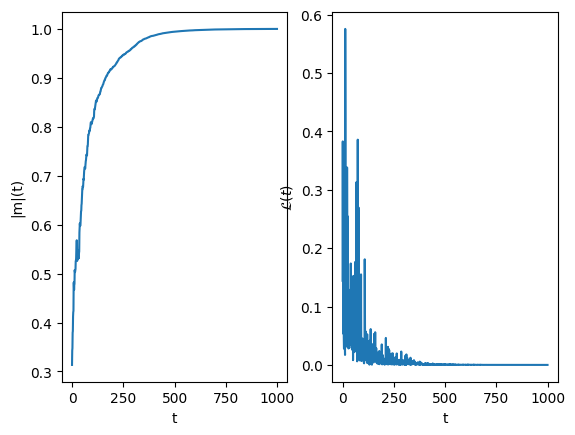

In [443]:
#main

N = 100
d = 30
eta = 1 # eta must be smaller than tau
tau = 10 # b must be bigger than eta/(tau+eta)
b = 0.1
m_0 = 0.2
iter_max = 1e3
isComplex = True
np_rd_seed = 0 # for the results to be reproductible


m_norm_all, loss_all = loop(N, d, eta, tau, b, m_0, iter_max, isComplex, np_rd_seed)

plot_magLoss_iter(m_norm_all, loss_all, iter_max)

### Code for p-SGD + SGD + GD graph
GD has $b=1$, $\tau$ can be anything

SDG has $\tau$ = $\frac{\eta}{b}$

p-SGD has them vary

In [462]:
def plot_descent_methods(m_norm, loss, labels, iter_max): #the m_norm and loss must be narrays of dim (diff_graphs, values)

    plt.subplot(1,2,1)
    plt.plot(np.arange(0,iter_max,1).T,m_norm.T,)
    plt.xlabel('t')
    plt.ylabel('|m|(t)')
    plt.xscale('log')
    plt.legend(labels)
    plt.subplot(1,2,2)
    plt.plot(np.arange(0,iter_max,1).T,loss.T)
    plt.xlabel('t')
    plt.ylabel('$\mathcal{L}(t)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(labels)
    plt.show()

In [501]:
N = 300
d = 100
eta = 0.1 # eta must be smaller than tau
b = np.array([1., 0.5, 0.5])
tau = np.array([1., eta/0.5, 1.]) # b must be bigger than eta/(tau+eta)
m_0 = 0.2
iter_max = 1e2
isComplex = False
np_rd_seed = np.arange(0,5,1) # for the results to be reproductible

graph_labels = ['GD','SGD','p-SGD']

m_graph, loss_graph = np.empty((3,int(iter_max))), np.empty((3,int(iter_max)))

for descent_type in range(3): # for each descent type, 500 different loops are taken over the narray np_rd_seed
    m_to_average, loss_to_average = np.empty((len(np_rd_seed),int(iter_max))), np.empty((len(np_rd_seed),int(iter_max)))
    for sample in tqdm(range(len(np_rd_seed))):
        m_to_average[sample], loss_to_average[sample] = loop(N, d, eta, tau[descent_type], b[descent_type], m_0, iter_max, isComplex, np_rd_seed[sample])
    m_graph[descent_type], loss_graph[descent_type] = np.mean(m_to_average,axis=0), np.mean(loss_to_average,axis=0)

data_graph = np.concatenate((m_graph,loss_graph))

np.savetxt("methods_comparaison.csv", data_graph, fmt="%.6f")

100%|██████████| 5/5 [00:22<00:00,  4.50s/it]


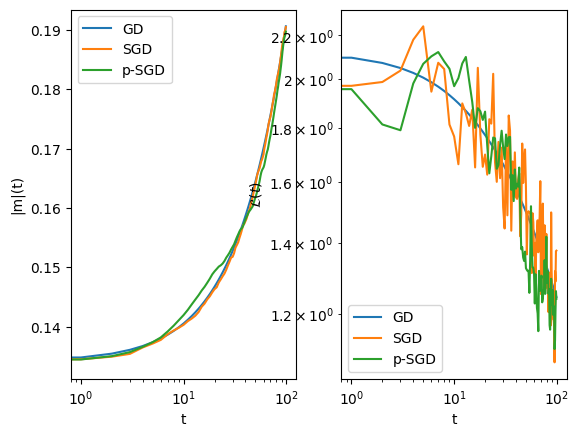

In [502]:
data_graph = np.genfromtxt('methods_comparaison.csv')
m_graph = data_graph[0:3]
loss_graph = data_graph[3:6]
plot_descent_methods(m_graph, loss_graph, graph_labels, int(iter_max))

In [499]:
a = np.arange(0,48,1)
b = np.reshape(a,(6,8))
b[0:6]

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47]])

### Random tests

In [126]:
m_norm_all_bis = m_norm_all
loss_all_bis = loss_all

<function matplotlib.pyplot.show(close=None, block=None)>

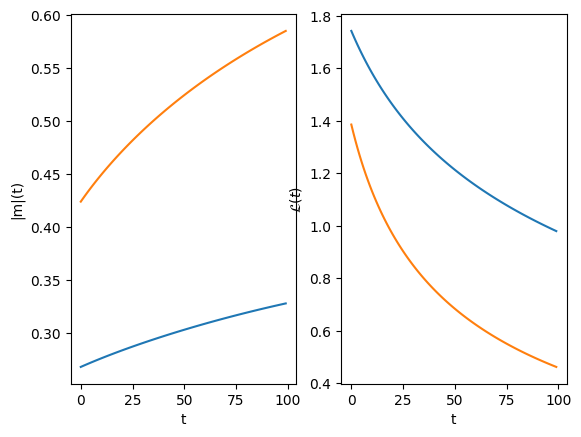

In [128]:
plt.subplot(1,2,1)
plt.plot(np.arange(0,iter_max,1),m_norm_all)
plt.plot(np.arange(0,iter_max,1),m_norm_all_bis)
plt.xlabel('t')
plt.ylabel('|m|(t)')
plt.subplot(1,2,2)
plt.plot(np.arange(0,iter_max,1),loss_all)
plt.plot(np.arange(0,iter_max,1),loss_all_bis)
plt.xlabel('t')
plt.ylabel('$\mathcal{L}(t)$')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

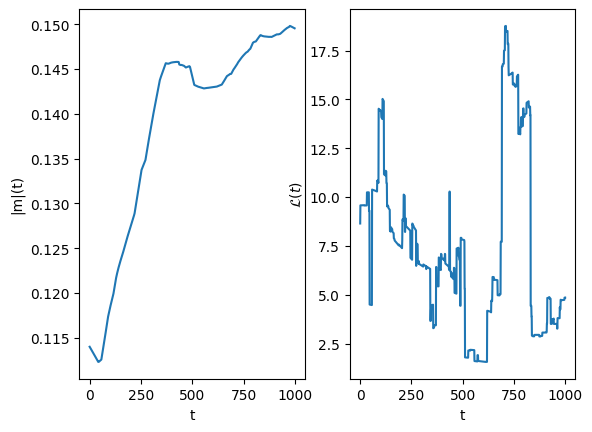

In [84]:
plt.subplot(1,2,1)
plt.plot(np.arange(0,iter_max,1),m_norm_all)
plt.xlabel('t')
plt.ylabel('|m|(t)')
plt.subplot(1,2,2)
plt.plot(np.arange(0,iter_max,1),loss_all)
plt.xlabel('t')
plt.ylabel('$\mathcal{L}(t)$')
plt.show

In [473]:
a = np.array([[[1,2],[3,4]],[[5,6],[7,8]]])
np.savetxt("some_data.csv", a, fmt="%.3f")

ValueError: Expected 1D or 2D array, got 3D array instead

In [471]:
b = np.genfromtxt('some_data.csv')
b

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [503]:
a = ['c','s','f']
b = ['d','3e','4']
a+b

['c', 's', 'f', 'd', '3e', '4']